NOTES
=====

Uses the cython heavily, based on the unmodified source 
(The optimization done by numpy cannot be exploited by cython)

The complete simulation has been moved to cython and optimized.

typed memory views
------------
The X, Y, and ConcPerCell Arrays have been used as a typed memory view.

type annotation
--------
Every single type annotation has been introduced, otherwise no changes

Boundschecking off
-----
Bounds checking off gives a speedup

Installing Cython
-----
pip3 install Cython


In [1]:
%matplotlib inline

from  matplotlib import pyplot 
%reload_ext Cython

In [2]:
%%cython

cimport cython

from libc.math cimport cos

cdef double VM2 = 20.0 # 10^-6 M/s
cdef double VM3 = 23.0 # 10^-6 M/s
cdef double K2 = 1.0 # 10^-6 M/s
cdef double KR = 0.8 # 10^-6 M/s
cdef double KA = 0.9 # 10^-6 M/s
cdef double kf = 1.0  # 1/s

cdef double k = 0.8  # 1/s
cdef double v = 0.325  # v= v0 + v1*beta

cdef double Dxl = 2.0  # 1/s
cdef double Dxr = 6.0  # 1/s
cdef double Dxd = 1.0  # 1/s
cdef double kt = 0.1 # 1/s

cdef double sampleFreq = 1.0 # s
cdef int duration = 5

cdef double h = 0.02
cdef int N = int(duration/h) + 1
#######################################
# Initial conditions
#######################################

cdef int ringsize=50
cdef int rings=200
#fileX = fromfile("X0.dat", sep=';')
#fileY = fromfile("Y0.dat", sep=';')



#X0 = np.zeros((ringsize,rings), double)
#Y0 = np.zeros((ringsize,rings), double)
#Amp = 0.55
#index=0
#for ring in range(0,3):
#    for cell in range(24,27):
#        X0[cell][ring] = Amp
#        Y0[cell][ring] = Amp 
#        index += 1          
  
#for ring in range(rings):
#    for cell in range(ringsize):
#        X0[cell][ring] = fileX[index]
#        Y0[cell][ring] = fileY[index] 
#        index += 1  


cdef double f(double X, double Y):
    return VM2*X/(K2+X) - VM3*Y*X*X/((KR+Y)*(KA*KA+X*X)) \
            - kf*Y

cdef double dXdt(double X, double Y, double flux):
    return v - f(X,Y) - k*X + flux

cdef double dYdt(double X,double Y):
    return f(X,Y)

@cython.boundscheck(False)
cpdef timestep(double[:,:,:] X, double[:,:,:] Y, double[:,:] cylinderConcPerCell, int index, 
               int ring, int t, int tau, double omega, double Am):
    cdef double flux
    cdef double x, y
    cdef double k11, k12, k21, k22, k31, k32, k41, kk42
    cdef double Xret, Yret
    cdef int cell
    for cell in range(0,ringsize): 
            flux = 0.0
# Sinus-Exitation
            if 0 <= ring <= 3:
                if 24 <= cell <= 27:
                    X[index][ring][cell] = Am*0.5*(1 + cos(omega*t*h))
#                   Y[index][ring][cell] = Amp*(math.cos(omega*t*h))**2
# horizontal diffusion
            if cell == 0:
                flux = Dxr*(X[index][ring][ringsize-1] - X[index][ring][cell]) \
                   + Dxl*(X[index][ring][1] - X[index][ring][cell])
            elif cell==ringsize-1:
                flux = Dxr*(X[index][ring][cell-1] - X[index][ring][cell]) \
                       + Dxl*(X[index][ring][0] - X[index][ring][cell])
            else :
                flux = Dxr*(X[index][ring][cell-1] - X[index][ring][cell]) \
                       + Dxl*(X[index][ring][cell+1] - X[index][ring][cell])
# vertical diffusion
            if ring == 0:
                if X[index][ring][cell] > X[index][ring+1][cell]:
                    flux -= Dxd*(X[index][ring][cell] - X[index][ring+1][cell])
            elif ring==rings-1:
                if X[index][ring-1][cell] > X[index][ring][cell]:
                    flux += Dxd*(X[index][ring-1][cell] - X[index][ring][cell])
            else:
                if X[index][ring-1][cell] > X[index][ring][cell]:
                    flux += Dxd*(X[index][ring-1][cell] - X[index][ring][cell])
                if X[index][ring][cell] > X[index][ring+1][cell]:
                    flux -= Dxd*(X[index][ring][cell] - X[index][ring+1][cell])

# Feedback across ring, tau elements back in time
            if t>=tau:
                flux += kt*(X[(t-tau)%tau][ring][(cell + ringsize//2)%ringsize]\
                              - X[index][ring][cell])


# Perform Runge-Kutta integration on current cell
            x = X[index][ring][cell]
            y = Y[index][ring][cell]
            k11 = h*dXdt(x,y,flux)
            k12 = h*dYdt(x,y)

            k21 = h*dXdt(x+0.5*k11, y+0.5*k12,flux)
            k22 = h*dYdt(x+0.5*k11, y+0.5*k12)

            k31 = h*dXdt(x+0.5*k21, y+0.5*k22,flux)
            k32 = h*dYdt(x+0.5*k21, y+0.5*k22)

            k41 = h*dXdt(x+k31, y+k32,flux)
            k42 = h*dYdt(x+k31, y+k32)

            Xret = x + (k11 + 2*k21 + 2*k31 + k41)/6
            Yret = y + (k12 + 2*k22 + 2*k32 + k42)/6
            X[(index+1)%tau][ring][cell] = Xret
            Y[(index+1)%tau][ring][cell] = Yret
            cylinderConcPerCell[cell][t] += X[index][ring][cell]
            

5/251, 	 2.0%, 	 elapsed: 0.1 	 ETA: 6.3
10/251, 	 4.0%, 	 elapsed: 0.1 	 ETA: 3.4
15/251, 	 6.0%, 	 elapsed: 0.2 	 ETA: 2.4
20/251, 	 8.0%, 	 elapsed: 0.2 	 ETA: 1.9
25/251, 	 10.0%, 	 elapsed: 0.2 	 ETA: 1.6
30/251, 	 12.0%, 	 elapsed: 0.2 	 ETA: 1.3
35/251, 	 13.9%, 	 elapsed: 0.2 	 ETA: 1.2
40/251, 	 15.9%, 	 elapsed: 0.2 	 ETA: 1.1
45/251, 	 17.9%, 	 elapsed: 0.2 	 ETA: 1.0
50/251, 	 19.9%, 	 elapsed: 0.2 	 ETA: 0.9
55/251, 	 21.9%, 	 elapsed: 0.3 	 ETA: 1.2
60/251, 	 23.9%, 	 elapsed: 0.3 	 ETA: 1.1
65/251, 	 25.9%, 	 elapsed: 0.4 	 ETA: 1.0
70/251, 	 27.9%, 	 elapsed: 0.4 	 ETA: 0.9
75/251, 	 29.9%, 	 elapsed: 0.4 	 ETA: 0.9
80/251, 	 31.9%, 	 elapsed: 0.4 	 ETA: 0.8
85/251, 	 33.9%, 	 elapsed: 0.4 	 ETA: 0.8
90/251, 	 35.9%, 	 elapsed: 0.4 	 ETA: 0.7
95/251, 	 37.8%, 	 elapsed: 0.4 	 ETA: 0.7
100/251, 	 39.8%, 	 elapsed: 0.4 	 ETA: 0.7
105/251, 	 41.8%, 	 elapsed: 0.6 	 ETA: 0.8
110/251, 	 43.8%, 	 elapsed: 0.6 	 ETA: 0.8
115/251, 	 45.8%, 	 elapsed: 0.6 	 ETA: 0.7
120/251, 	 4

Text(0.5,1,'Vertical diff sum through cylinder\n Dxr = 6.0, Dxl = 2.0, k=0.8')

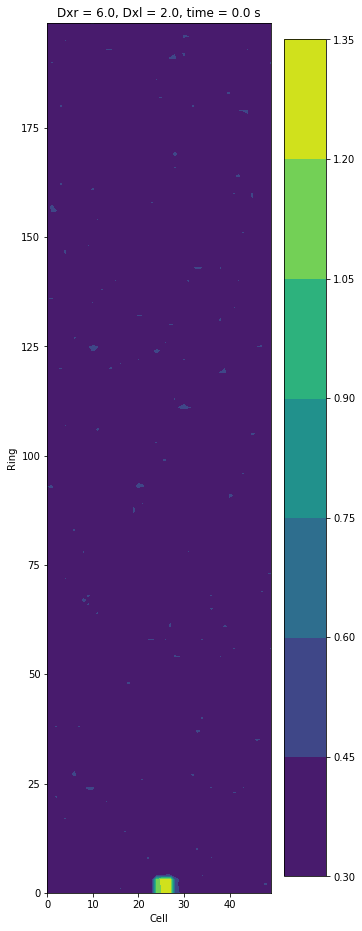

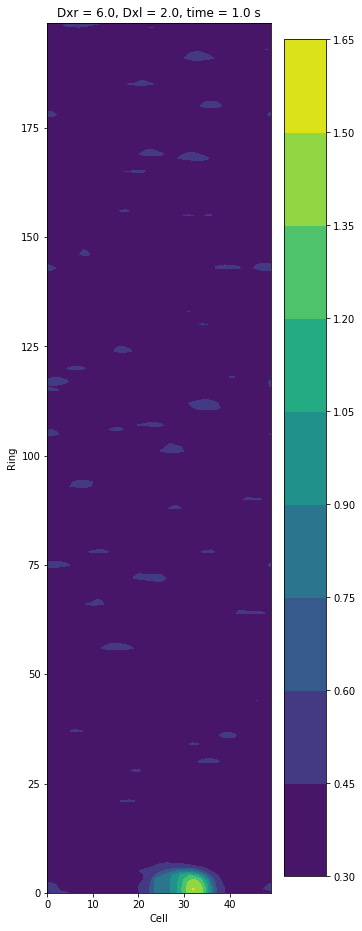

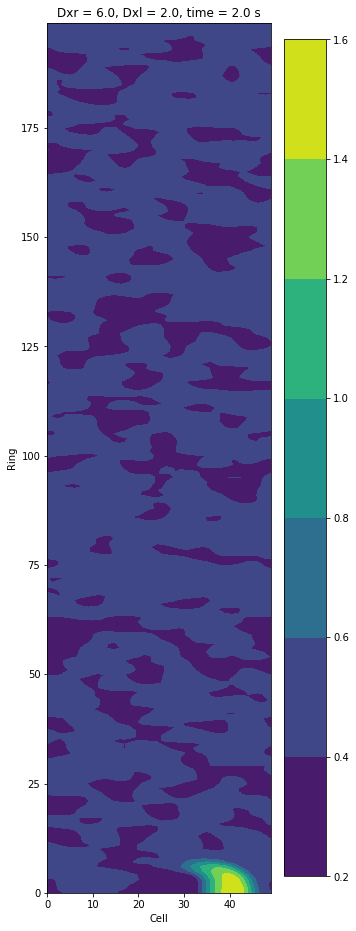

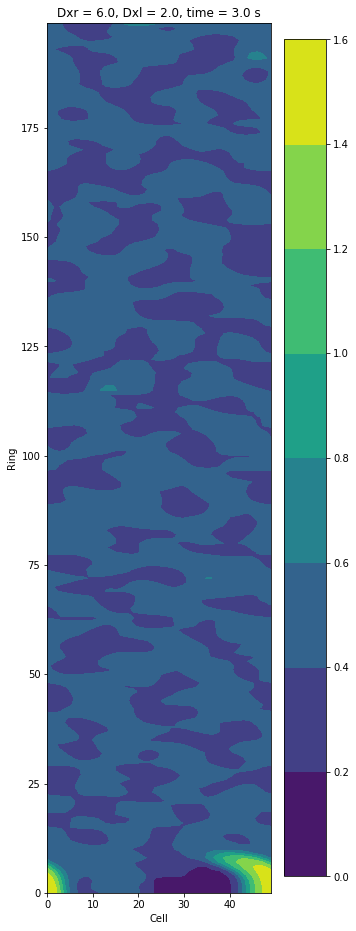

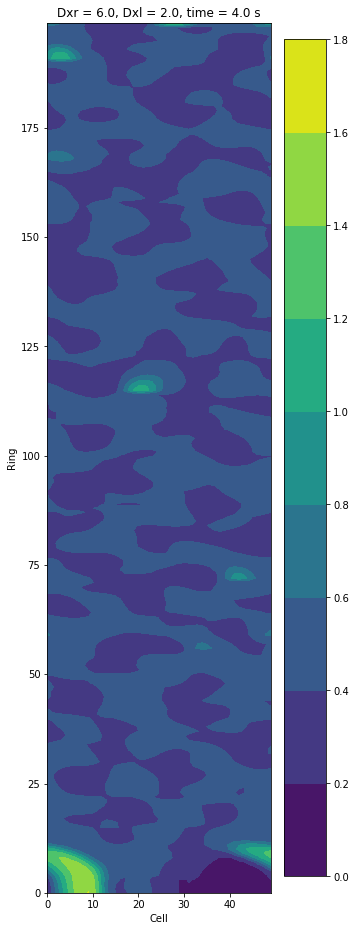

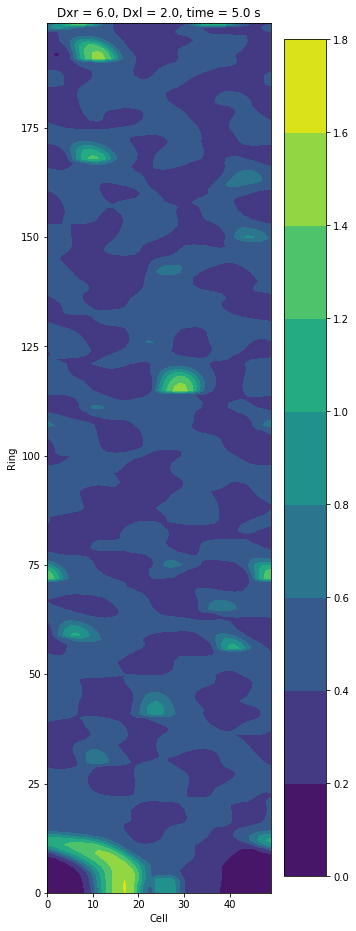

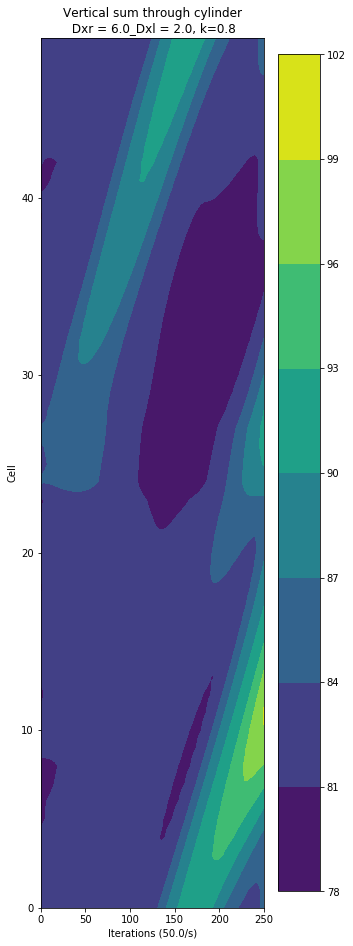

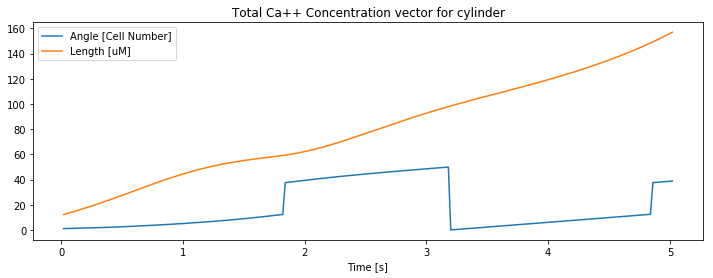

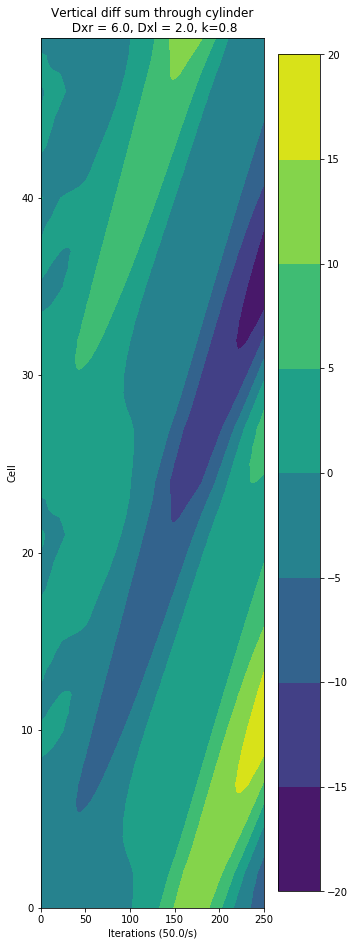

In [3]:
# Original Code
#######################################
#######################################
## 50x50Nodes.py
##
## Runge-Kutta simulation of 50 cells/ring x 50 rings with feedback
## Create image contour plots of full X matrix at given intervals
## Calculate sum through column and difference in sum across ring
##
##Store minimal amount of data in RAM
#######################################
#######################################


#######################################
# Library imports
#######################################


import time as mytime
import math
import numpy as np

np.random.seed(1234)
#######################################
# Constants
#######################################

VM2 = 20.0 # 10^-6 M/s
VM3 = 23.0 # 10^-6 M/s
K2 = 1.0 # 10^-6 M/s
KR = 0.8 # 10^-6 M/s
KA = 0.9 # 10^-6 M/s
kf = 1.0  # 1/s

k = 0.8  # 1/s
v = 0.325  # v= v0 + v1*beta

tau = 16 # s

Dxl = 2.0  # 1/s
Dxr = 6.0  # 1/s
Dxd = 1.0  # 1/s
kt = 0.1 # 1/s

sampleFreq = 1.0 # s
duration = 5


#######################################
# Initial conditions
#######################################

ringsize=50
rings=200
#fileX = fromfile("X0.dat", sep=';')
#fileY = fromfile("Y0.dat", sep=';')
omega = 1.047
Am =  1.2

#X0 = np.zeros((ringsize,rings), double)
#Y0 = np.zeros((ringsize,rings), double)
#Amp = 0.55
#index=0
#for ring in range(0,3):
#    for cell in range(24,27):
#        X0[cell][ring] = Amp
#        Y0[cell][ring] = Amp 
#        index += 1          
  
#for ring in range(rings):
#    for cell in range(ringsize):
#        X0[cell][ring] = fileX[index]
#        Y0[cell][ring] = fileY[index] 
#        index += 1  
        
X0 = (np.random.rand(ringsize,rings)-0.5)*0.1 + 0.406
Y0 = (np.random.rand(ringsize,rings)-0.5)*0.2 + 2.76

#######################################
# Functions
#######################################

# Log data to file
def writeRing(filename,data,ring):
    f= open (filename + str(ring) + '.dat', 'w')
    for t in range(0,N):
        string = ""
        for cell in range(0,ringsize-1):
            string += str(data[t][ring][cell]) + ';'
        string += str(data[t][ring][ringsize-1]) + '\n'
        f.write(string) 

def writeCylinder(filename,data,ring):
    f= open (filename + str(ring) + '.dat', 'w')
    for ring in range(0,rings):
        string = ""
        for cell in range(0,ringsize-1):
            string += str(data[time%tau][ring][cell]) + ';'
        string += str(data[time%tau][ring][ringsize-1]) + '\n'
        f.write(string) 
        
        
#######################################
# Perform simulation
#######################################

# Set step size 
h = 0.02
N = int(duration/h) + 1

sampleFreq = sampleFreq/h
tau = int(tau/h)

cylinderConcPerCell = np.zeros((ringsize,N),float)
totalConcVector = np.zeros((2,N),float)
angle = 2*math.pi/ringsize

# initialize X and Y matrices
# X[time][ring][cell]
X = np.zeros((tau,rings, ringsize),float)
Y = np.zeros((tau,rings, ringsize),float)
for ring in range(rings):
    for cell in range(ringsize):
        X[0][ring][cell] = X0[cell][ring]
        Y[0][ring][cell] = Y0[cell][ring]

time = np.arange(0,h*N+h,h)

# Loop over all cells and time points
startTime = mytime.time()
for t in range(0,N):
    index = t%tau
    for ring in range(0,rings):
        timestep(X, Y, cylinderConcPerCell, index, ring, t, tau, omega, Am)
            
# Generate progress output to standard out        
    if t%5==0 and t!=0:
        elapsed = mytime.time()-startTime
        ratio = 1.0*t/N
        print ('%d/%d, \t %.1f%%, \t elapsed: %.1f \t ETA: %.1f'\
               % (t, N, ratio*100, elapsed, elapsed/ratio-elapsed))
   
# Write data output to files
    if t%sampleFreq==0:
# Write raw data to files
#        writeCylinder('outputX_F_Dxr_' + str(Dxr) + '_k_' + ':', X, t)
#        writeCylinder('outputY_F_Dxr_' + str(Dxr) + '_k_' + ':', Y, t)

# Write X matrix to image file
        fig = pyplot.figure(figsize=(5,16))
        pyplot.clf()
        fig = pyplot.contourf(X[(index+1)%tau,:,:])
        pyplot.xlabel('Cell')
        pyplot.ylabel('Ring')
        pyplot.colorbar()
        pyplot.title('Dxr = ' + str(Dxr) + ', Dxl = ' + str(Dxl) + ', time = ' + str(t*h) + ' s')
        
        
#######################################
# Post processing
#######################################

# calculate total concentration totalConcVector 
    x = 0
    y = 0
    for cell in range(0,ringsize):
        x += cylinderConcPerCell[cell][t]*math.cos(angle*cell)
        y += cylinderConcPerCell[cell][t]*math.sin(angle*cell)
        
# Angle
    totalConcVector[0][t] = math.atan(y/x)
    if totalConcVector[0][t]<0:
        totalConcVector[0][t] += 2*math.pi
    totalConcVector[0][t] = totalConcVector[0][t]/2/math.pi*ringsize
# Length
    totalConcVector[1][t] = math.sqrt(x*x+y*y)
    
    
    
# Calculate total diff concentration vector across cylinderConcPerCell
totalDiffConcVector = np.zeros((ringsize,N),float)
for t in range(N):
    for cell in range(ringsize):
        totalDiffConcVector[cell][t] = cylinderConcPerCell[cell][t] - cylinderConcPerCell[(cell + ringsize//2)%ringsize][t]
        
        
        
# Plot Cylinder Sum
fig = pyplot.figure(figsize=(5,16))
pyplot.clf()
fig = pyplot.contourf(cylinderConcPerCell)
pyplot.xlabel('Iterations (' + str(1/h) + '/s)')
pyplot.ylabel('Cell')
pyplot.colorbar()
pyplot.title('Vertical sum through cylinder\n Dxr = ' + str(Dxr) + '_Dxl = ' + str(Dxl) +\
      ', k='+ str(k))


fig = pyplot.figure(figsize=(12,4))
pyplot.clf()
pyplot.plot(time[1:], totalConcVector[0][:], label='Angle [Cell Number]')
pyplot.plot(time[1:], totalConcVector[1][:], label='Length [uM]')
pyplot.legend()
pyplot.xlabel('Time [s]')
pyplot.title('Total Ca++ Concentration vector for cylinder')
        
        
# Plot Diff Cylinder Sum
fig = pyplot.figure(figsize=(5,16))
pyplot.clf()
fig = pyplot.contourf(totalDiffConcVector)
pyplot.xlabel('Iterations (' + str(1/h) + '/s)')
pyplot.ylabel('Cell')
pyplot.colorbar()
pyplot.title('Vertical diff sum through cylinder\n Dxr = ' + str(Dxr) + ', Dxl = ' +  str(Dxl) +\
      ', k='+ str(k))
